In [1]:
import os
import sys

import shutil
os.chdir("G:\\My Drive\\Ingegneria\\Data Science GD\\Models\\Trading\\Stocks Reinforcement Learning Ensemble") # set cwd

import time
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from stable_baselines3 import SAC
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3 import HER
from stable_baselines3 import DQN

from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from env.Environment import EnvSetup
from env.EnvMultipleStockTrain import StockEnvTrain
from env.EnvMultipleStockValidation import StockEnvValidation
from env.EnvMultipleStockTrade import StockEnvTrade

import talib

from inputs import config_

import yfinance as yf


In [2]:
def calc_turbulence(df):

    # pivot the original df to get the correct format (one column per tickers) for the turbulence calculation
    df_pivot = df.pivot(index='Date', columns='Ticker', values='Adj Close')

    # calculate the daily returs for each ticker
    returns = df_pivot.pct_change()

    # Calculate the mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Calculate the turbulence index for each day
    turbulence_index = pd.Series(index=returns.index)
    for i in range(len(returns)):
        diff = returns.iloc[i] - mean_returns
        turbulence_index[i] = diff.dot(np.linalg.inv(cov_matrix)).dot(diff.T) #  to weight each element of the diff vector by how much it contributes to the overall variance of the asset returns.

    # Normalize the turbulence index
    turbulence_index = turbulence_index / len(df_pivot.columns)
    df_turb = pd.DataFrame(turbulence_index)
    
    df = df.merge(df_turb, on='Date')
    df = df.rename(columns={0: 'Turbulence'})

    return df

In [3]:
# tickers = config_.DOW_30_TICKER

# df = pd.DataFrame()
    
# for ticker in tickers:
#     ticker_df = yf.download(ticker, start= "2000-01-01", end= "2024-01-01") 
#     ticker_df.sort_values('Date', inplace=True)
#     ticker_df['MACD'], ticker_df['MACD_signal'], ticker_df['MACD_hist'] = talib.MACD(ticker_df['Adj Close'])
#     ticker_df['RSI21'] = talib.RSI(ticker_df['Adj Close'], timeperiod=21)
#     ticker_df['CCI21'] = talib.CCI(ticker_df['High'], ticker_df['Low'], ticker_df['Adj Close'], timeperiod=21)
#     ticker_df['ATR21'] = talib.ATR(ticker_df['High'], ticker_df['Low'], ticker_df['Adj Close'], timeperiod=21)
#     ticker_df['+DMI21'] = talib.PLUS_DI(ticker_df['High'],ticker_df['Low'],ticker_df['Adj Close'],timeperiod=21)
#     ticker_df['-DMI21'] = talib.MINUS_DI(ticker_df['High'],ticker_df['Low'],ticker_df['Adj Close'],timeperiod=21)
#     ticker_df['ADX21'] = talib.ADX(ticker_df['High'],ticker_df['Low'],ticker_df['Adj Close'],timeperiod=21)
#     ticker_df['Ticker'] = ticker 
#     df = pd.concat([df, pd.DataFrame(ticker_df)])

# df.to_csv('inputs/df.csv')

In [4]:
df = pd.read_csv('inputs/df.csv')
df = calc_turbulence(df)
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_signal,MACD_hist,RSI21,CCI21,ATR21,+DMI21,-DMI21,ADX21,Ticker,Turbulence
0,2000-03-02,39.972034,40.099682,38.622612,38.969086,28.033796,8707643,-1.293481,-0.903550,-0.389931,38.985916,-79.601865,13.084495,1.622394,4.058675,25.259126,AXP,2.894102
1,2000-03-02,65.312500,67.875000,63.000000,65.312500,47.318504,12075000,0.252899,0.467997,-0.215098,49.093379,-59.373498,20.665390,4.504472,5.366076,5.934448,AMGN,2.894102
2,2000-03-02,1.133929,1.142299,1.077567,1.089286,0.923366,311259200,0.030402,0.025507,0.004895,54.648514,185.295293,0.185088,8.904059,6.538580,7.513739,AAPL,2.894102
3,2000-03-02,36.312500,37.187500,35.375000,35.937500,23.276478,4058200,-1.093186,-0.987795,-0.105392,42.392385,-87.275586,15.007689,2.054148,2.558177,13.337771,BA,2.894102
4,2000-03-02,17.437500,17.500000,17.093750,17.218750,9.199947,3956000,-0.805224,-0.838973,0.033749,31.265131,-130.439186,10.154435,1.229186,2.952335,32.993898,CAT,2.894102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161887,2023-12-29,525.979980,528.239990,523.919983,526.469971,526.469971,2080100,-4.245183,-2.773944,-1.471239,46.875479,-53.075642,7.756212,16.717518,22.727781,19.353647,UNH,0.095340
161888,2023-12-29,37.380001,37.759998,37.320000,37.700001,37.074799,16205200,0.248788,0.379503,-0.130715,58.130337,-29.525042,0.958489,13.990541,10.249013,25.282952,VZ,0.095340
161889,2023-12-29,26.440001,26.629999,25.750000,26.110001,26.110001,10853300,1.384881,1.233025,0.151857,65.720441,71.969465,0.863913,30.914270,13.810820,29.463601,WBA,0.095340
161890,2023-12-29,157.529999,158.080002,157.160004,157.649994,157.649994,7314200,-0.028408,-0.821300,0.792892,52.068674,137.706863,2.131293,23.471639,21.698666,14.348200,WMT,0.095340


In [5]:
corr = df.drop(['Date', 'Ticker'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_signal,MACD_hist,RSI21,CCI21,ATR21,+DMI21,-DMI21,ADX21,Turbulence
Open,1.000000,0.999894,0.999880,0.999785,0.988357,-0.180593,0.193583,0.203480,0.011287,0.072701,0.034190,0.300553,0.487937,0.437207,0.007695,-0.110582
High,0.999894,1.000000,0.999827,0.999891,0.988532,-0.180363,0.191744,0.201347,0.011778,0.072735,0.035021,0.300425,0.489605,0.439033,0.008215,-0.107215
Low,0.999880,0.999827,1.000000,0.999889,0.988351,-0.180893,0.196544,0.205653,0.014272,0.076640,0.037889,0.300678,0.487018,0.434367,0.007336,-0.113763
Close,0.999785,0.999891,0.999889,1.000000,0.988536,-0.180641,0.194539,0.203488,0.014327,0.076521,0.037973,0.300530,0.488515,0.436505,0.007883,-0.110176
Adj Close,0.988357,0.988532,0.988351,0.988536,1.000000,-0.151795,0.192786,0.201434,0.014858,0.071236,0.035274,0.153907,0.565246,0.511568,0.007744,-0.111540
Volume,-0.180593,-0.180363,-0.180893,-0.180641,-0.151795,1.000000,-0.021307,-0.021249,-0.004679,0.004862,-0.003062,-0.223404,0.045221,0.052682,0.095706,0.050510
MACD,0.193583,0.191744,0.196544,0.194539,0.192786,-0.021307,1.000000,0.950237,0.360389,0.587740,0.396716,0.006029,0.213788,-0.217844,0.050567,-0.151810
MACD_signal,0.203480,0.201347,0.205653,0.203488,0.201434,-0.021249,0.950237,1.000000,0.051860,0.519976,0.262098,0.012208,0.182050,-0.199596,0.061160,-0.146085
MACD_hist,0.011287,0.011778,0.014272,0.014327,0.014858,-0.004679,0.360389,0.051860,1.000000,0.327142,0.486940,-0.017228,0.140222,-0.100688,-0.021031,-0.049232
RSI21,0.072701,0.072735,0.076640,0.076521,0.071236,0.004862,0.587740,0.519976,0.327142,1.000000,0.799950,-0.012843,0.117729,-0.238274,0.124781,-0.157293


In [6]:
df = df.drop(['Open','High','Low','Close','MACD_signal'], axis=1)

df = df[df.Ticker.isin(config_.DOW_sel_TICKER)]

df

,Date,Adj Close,Volume,MACD,MACD_hist,RSI21,CCI21,ATR21,+DMI21,-DMI21,ADX21,Ticker,Turbulence
2,2000-03-02,0.923366,311259200,0.030402,0.004895,54.648514,185.295293,0.185088,8.904059,6.538580,7.513739,AAPL,2.894102
3,2000-03-02,23.276478,4058200,-1.093186,-0.105392,42.392385,-87.275586,15.007689,2.054148,2.558177,13.337771,BA,2.894102
11,2000-03-02,33.326828,36469800,1.407970,-0.003581,63.005642,144.403158,23.445025,2.983329,1.695648,35.449994,INTC,2.894102
13,2000-03-02,12.807508,11358600,-0.692297,-0.047209,41.385618,-67.544201,13.849772,1.292476,1.706274,16.570925,KO,2.894102
18,2000-03-02,28.944557,106932600,-1.275920,-0.029269,38.402806,-73.891219,20.064617,1.455838,2.813625,32.943463,MSFT,2.894102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161876,2023-12-29,50.250000,29266500,2.323294,0.393488,70.657071,131.160303,1.274397,39.003296,11.804960,36.828063,INTC,0.095340
161878,2023-12-29,58.930000,9241600,0.324693,-0.097240,57.469803,37.821509,0.752743,21.037559,19.236289,12.019576,KO,0.095340
161883,2023-12-29,376.040009,18723000,2.688171,-0.502421,58.435836,96.528979,5.629226,25.185862,15.037656,25.397692,MSFT,0.095340
161884,2023-12-29,108.570000,7660900,0.089720,-1.908133,45.833113,-98.250580,2.597086,26.608330,30.909741,26.146247,NKE,0.095340


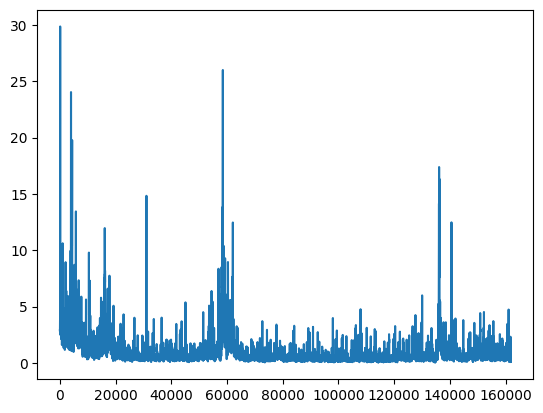

Series([], Name: Date, dtype: object) Twin Towers
Series([], Name: Date, dtype: object) Market Crush
Series([], Name: Date, dtype: object) Covid


In [7]:
plt.plot(df.Turbulence)
plt.show()
print(df[df.index==10000].Date, 'Twin Towers')
print(df[df.index==60000].Date, 'Market Crush')
print(df[df.index==135000].Date, 'Covid')

''' Models and Validation Functions'''

In [8]:
# The total_timesteps parameter in the learn methods of the A2C, DDPG, and PPO models refers to the total number of steps that the agent will take for any environment during training. Increasing the total_timesteps parameter means that the agent will take more steps during training, which could potentially lead to better performance as the agent has more opportunities to learn from the environment. However, this also means that training will take longer.

def train_A2C(env_train, model_name, timesteps, working_path):
    start = time.time()
    model = A2C('MlpPolicy', env_train,
                n_steps = config_.A2C_PARAMS['n_steps'],
                ent_coef = config_.A2C_PARAMS['ent_coef'],
                learning_rate = config_.A2C_PARAMS['learning_rate'],
                verbose = config_.A2C_PARAMS['verbose'])
    model.learn(total_timesteps=config_.A2C_PARAMS['timesteps'])
    end = time.time()
    model.save(working_path+'/'+model_name)
    print(' - Training time (A2C): ', (end - start) / 60, ' minutes')    
    return model

def train_PPO(env_train, model_name, timesteps, working_path):
    start = time.time()
    model = PPO('MlpPolicy', env_train, 
                n_steps = config_.PPO_PARAMS['n_steps'],
                ent_coef = config_.PPO_PARAMS['ent_coef'],
                learning_rate = config_.PPO_PARAMS['learning_rate'],
                batch_size = config_.PPO_PARAMS['batch_size'],
                verbose = config_.PPO_PARAMS['verbose'])    
    model.learn(total_timesteps=config_.PPO_PARAMS['timesteps'])
    end = time.time()
    model.save(working_path+'/'+model_name)
    print(' - Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

def train_DDPG(env_train, model_name, timesteps, working_path):
    # add the noise objects for DDPG    # param_noise = None
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions)) # This is a type of noise that is commonly used in DDPG algorithms to promote exploration.
    start = time.time()
    model = DDPG('MlpPolicy', env_train, 
                 learning_rate = config_.DDPG_PARAMS['learning_rate'],
                 batch_size = config_.DDPG_PARAMS['batch_size'],
                 buffer_size = config_.DDPG_PARAMS['buffer_size'],
                 verbose = config_.DDPG_PARAMS['verbose'],
                 action_noise=action_noise) 
    model.learn(total_timesteps=config_.DDPG_PARAMS['timesteps'])
    end = time.time()
    model.save(working_path+'/'+model_name)
    print(' - Training time (DDPG): ', (end-start)/60,' minutes')
    return model

        
def DRL_validation(model, validation_data, env_val, init_obs_val):
    total_reward = 0
    # In each iteration of the loop, the model makes a prediction based on the current observation state (obs_val). This prediction are the actions that the model decides to take given the current state.
    obs_val = init_obs_val
    for i in range(len(validation_data.index.unique())):
        actions, _states = model.predict(obs_val)
        obs_val, rewards, dones, info = env_val.step(actions=actions)
        total_reward += rewards
    print('\npredicted validation actions (last day)\n',actions)
    return total_reward
                
        
def get_validation_sharpe(model_name, working_path):
    df_total_value = pd.read_csv(working_path+'/account_value_validation_{}.csv'.format(model_name), index_col=0)
    df_total_value.columns = ['account_value_validation'] # account_value_train before
    df_total_value['daily_return'] = df_total_value.pct_change(1)
    sharpe = np.sqrt(252) * df_total_value['daily_return'].mean() / df_total_value['daily_return'].std() 
    return df_total_value, sharpe


def plot_datasets(df, start_index, train_init_quarters, valid_quarters, trade_quarters, initial_amount):
    # Define the colors for the different data sets
    colors = {'train': 'blue', 'valid': 'green', 'trade': 'red'}
    revenues = {}

    # Calculate the indices for the different data sets
    train_end_index = start_index + train_init_quarters * 63
    valid_end_index = train_end_index + valid_quarters * 63
    trade_end_index = valid_end_index + trade_quarters * 63

    # Get the unique stock symbols
    tickers = df['Ticker'].unique()
    init_amount_stock = initial_amount/df['Ticker'].nunique()

    # Create a separate plot for each stock
    for ticker in tickers:
        # Filter the data for the current stock
        stock_data = df[df['Ticker'] == ticker]

        # Get the stock prices at the beginning and end of the trading period
        start_trade_price = stock_data['Adj Close'][valid_end_index]
        end_trade_price = stock_data['Adj Close'][trade_end_index]
        # Calculate the revenue
        fin_amount_stock = init_amount_stock/start_trade_price*end_trade_price
        
        revenues[ticker] = fin_amount_stock
        
        # Plot the data
        plt.figure(figsize=(14, 7))
        plt.plot(stock_data.index[start_index:train_end_index], 
                 stock_data['Adj Close'][start_index:train_end_index], 
                 color=colors['train'], label='Train')
        plt.plot(stock_data.index[train_end_index:valid_end_index], 
                 stock_data['Adj Close'][train_end_index:valid_end_index], 
                 color=colors['valid'], label='Valid')
        plt.plot(stock_data.index[valid_end_index:trade_end_index], 
                 stock_data['Adj Close'][valid_end_index:trade_end_index], 
                 color=colors['trade'], label='Trade')

        # Add labels and title
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'Stock Closing Prices for {ticker}')
        plt.legend()
        
        # Print the initial and final revenue on the plot
        plt.text(valid_end_index, start_trade_price, f'Initial Amount: {init_amount_stock}')
        plt.text(trade_end_index, end_trade_price, f'Final Amount: {fin_amount_stock}')

        # Show the plot
        plt.show()
    
    steady_revenue = sum(revenues.values())
    return steady_revenue

''' ENSEMBLE train & validation'''

In [9]:
'''
The run_ensemble_strategy function is designed to train and validate multiple reinforcement learning models (A2C, PPO, DDPG), through a TimeSeriesSplit cross validation algorithm, select the best model based on the Sharpe ratio, retrain it on the whole 'train+validation' dataset, and then use that model to make predictions on the 'trade' dataset.
'''

def run_strategy(df, date_start="0000-00-00", train_init_quarters= 4, valid_quarters=4, trade_quarters=4, 
                          rebalance_quarters=1, max_rebalances_input=None):
    
    start = time.time()
        
    df.index = df.Date.factorize()[0] # to create a index with a unique value for each Date
    
    all_dates_sorted = np.sort(df.Date.unique())       
    start_index = np.searchsorted(all_dates_sorted, max(date_start,all_dates_sorted[1])) # starting at least from the second position
    
    steady_revenue = plot_datasets(df, start_index,train_init_quarters, valid_quarters, trade_quarters, config_.initial_amount)
    
    dates_sorted = all_dates_sorted[start_index:]
    date_before_start = all_dates_sorted[start_index - 1]
    
    all_quarters = len(dates_sorted)//63 # 63 = trade days per quarter
    max_rebalances_allowed = all_quarters-train_init_quarters-valid_quarters-trade_quarters
    
    if max_rebalances_input == None: # no user input
        rebalances = max_rebalances_allowed
    else:
        rebalances = min(max_rebalances_input, max_rebalances_allowed)
    
    if rebalances < 1:
        print('Enter valid date range')
        sys.exit()
    
    working_folder_name = 'FROM('+str(date_start)+ \
    ')_QUARTERS('+str(train_init_quarters)+'-'+str(valid_quarters)+'-'+str(trade_quarters)+ \
    ')_REBALANCES('+str(rebalances)+'-'+str(rebalance_quarters)+ \
    ')_TS('+str(config_.A2C_PARAMS['timesteps'])+'-'+str(config_.DDPG_PARAMS['timesteps'])+'-'+str(config_.PPO_PARAMS['timesteps'])+')'
    
    working_path = 'working/'+working_folder_name
    # Check if the directory exists
    if os.path.exists(working_path):
        # Delete directory and all files in the directory
        shutil.rmtree(working_path)
    # Create the directory
    os.makedirs(working_path)
    
    stocks_dim = df.Ticker.nunique()
    state_space = 1 + (len(config_.TECHNICAL_INDICATORS_LIST) + 2) * stocks_dim # stocks_dimension * (Close Price, Shares owned, MACD, RSI, CCI, ADX) + Balance
    
    # Initialize variables: Lists are created to store the last state of the ensemble model and the Sharpe ratios of the different models.
    last_state_ensemble = []
    ppo_sharpe_list = []
    ddpg_sharpe_list = []
    a2c_sharpe_list = []
    
    #implementing TimeSeriesSplit, with increasing train quarter window and fixed validation and trade windows
    for i in range(0, rebalances*rebalance_quarters, rebalance_quarters):
        train_end_ind = (start_index + train_init_quarters*63 + i*63) * stocks_dim
        validation_end_ind = (start_index + train_init_quarters*63 + valid_quarters*63 + i*63) * stocks_dim
    
        train_data = df.iloc[start_index*stocks_dim:train_end_ind]
        validation_data = df.iloc[train_end_ind:validation_end_ind]
        
        retrain_data = df.iloc[start_index*stocks_dim:validation_end_ind]
        trade_data = df.iloc[validation_end_ind : validation_end_ind+trade_quarters*63*stocks_dim]
        
        initial_close_train = df[df.Date == date_before_start]['Adj Close'].to_list()
        # print('initial_close_train',initial_close_train, date_before_start)
        initial_close_valid = train_data['Adj Close'].iloc[-1*stocks_dim:].tolist()
        # print('initial_close_valid',initial_close_valid, max(train_data.Date))
        initial_close_trade = retrain_data['Adj Close'].iloc[-1*stocks_dim:].tolist()
        # print('initial_close_trade',initial_close_trade, max(retrain_data.Date))
        
        insample_turbulence_threshold = np.quantile(df.iloc[start_index:train_end_ind].Turbulence.unique(), .90) # 90% quantile 
        historical_turbulence_mean = np.mean(df.iloc[start_index:train_end_ind].Turbulence.unique())
        # calculates the turbulence threshold for the current iteration based on historical turbulence
        if historical_turbulence_mean > insample_turbulence_threshold:
            # The turbulence threshold is a measure of market uncertainty or risk. When market is more volatile, risk is higher. By setting a lower turbulence threshold, the model becomes more conservative: more likely to trigger the turbulence condition, signaling high risk.
            # if the mean of the historical data is greater than the 90% quantile of insample turbulence data, the current market is volatile, therefore we set the 90% quantile of insample turbulence data as the turbulence threshold (maximum allowed threshold)
            turbulence_threshold = insample_turbulence_threshold
        else:
            #On the other hand, when the market is less volatile, the risk is lower. By setting a higher turbulence threshold during these times, the model allows for more aggressive strategies because it’s less likely to trigger the turbulence condition.
            # if the mean of the historical data is less than the 90% quantile of insample turbulence data, then we set a 99% risk threshold
            turbulence_threshold = np.quantile(df.Turbulence.unique(), .99) 
        

        print('cycle')
        print(i)
        print('train indexes')
        print(start_index*stocks_dim, train_end_ind)
        print('validation indexes')
        print(train_end_ind, validation_end_ind)
        print('lenght of the datasets:')
        print(len(train_data), len(validation_data))
        print('min and max train date')
        print(min(train_data.Date), max(train_data.Date))
        print('min and max validation date')
        print(min(validation_data.Date), max(validation_data.Date))
        print('train dataset.shape')
        print(train_data.shape)
        print('validation dataset.shape')
        print(validation_data.shape) 
        print(" - insample_turbulence_threshold: - ")
        print(insample_turbulence_threshold) 
        print(" - historical_turbulence_mean: - ")
        print(historical_turbulence_mean)
        print(" - Turbulence_threshold: - ")
        print(turbulence_threshold)

            
        env_setup = EnvSetup(stocks_dim = stocks_dim,
                             state_space = state_space,
                             hmax = 100,
                             initial_amount = 1000000,
                             transaction_cost_pct = 0.001,
                             working_path = working_path)


        if config_.ensemble_training == True:  ########################################################################################3

            
            print('-------------------------------------------------------------------------------------------')
            print(" - Model train from: ", min(train_data.Date), "to ", max(train_data.Date))
            print(" - Model validation from: ", min(validation_data.Date), "to ", max(validation_data.Date))
            print('-------------------------------------------------------------------------------------------')
                   
            #DDPG

            model_name_ddpg = 'DDPG_cycle{:02d}_timesteps{}'.format(int(i/rebalance_quarters+1),config_.DDPG_PARAMS['timesteps'])

            env_train, _ = env_setup.create_environment(data = train_data, env_class = StockEnvTrain, 
                                                        initial_close = initial_close_train, model_name=model_name_ddpg)

            env_val, init_obs_val = env_setup.create_environment(data = validation_data, env_class = StockEnvValidation,
                                        initial_close = initial_close_valid, model_name=model_name_ddpg, turbulence_threshold=turbulence_threshold)

            print(" - DDPG Training in progress...")
            model_ddpg = train_DDPG(env_train, model_name=model_name_ddpg, timesteps=config_.DDPG_PARAMS['timesteps'], working_path=working_path) 
            print(" - DDPG Training completed!")
            print(" - DDPG Validation in progress...")
            val_reward_ddpg = DRL_validation(model=model_ddpg, validation_data=validation_data, env_val=env_val, init_obs_val=init_obs_val)
            print(" - DDPG Validation completed!") 
            print('DDPG Validation Reward:', val_reward_ddpg)
            df_total_value_ddpg, sharpe_ddpg = get_validation_sharpe(model_name_ddpg, working_path)
            print('df_total_value_ddpg')
            print(df_total_value_ddpg)
            print(" - DDPG Sharpe Ratio: ", sharpe_ddpg)          


            # A2C

            model_name_a2c = 'A2C_cycle{:02d}_timesteps{}'.format(int(i/rebalance_quarters+1),config_.A2C_PARAMS['timesteps'])

            env_train, _ = env_setup.create_environment(data = train_data, env_class = StockEnvTrain, 
                                                        initial_close = initial_close_train, model_name=model_name_a2c)

            env_val, init_obs_val = env_setup.create_environment(data = validation_data, env_class = StockEnvValidation,  
                                    initial_close = initial_close_valid, model_name=model_name_a2c, turbulence_threshold=turbulence_threshold)

            print(" - A2C Training in progress...")
            model_a2c = train_A2C(env_train, model_name=model_name_a2c, timesteps=config_.A2C_PARAMS['timesteps'], working_path=working_path) 
            print(" - A2C Training completed!")
            print(" - A2C Validation in progress...")
            val_reward_a2c = DRL_validation(model=model_a2c, validation_data=validation_data, env_val=env_val, init_obs_val=init_obs_val)
            print(" - A2C Validation completed!")        
            print('A2C Validation Reward:', val_reward_a2c)
            df_total_value_a2c, sharpe_a2c = get_validation_sharpe(model_name_a2c, working_path)
            print('df_total_value_a2c')
            print(df_total_value_a2c)
            print(" - A2C Sharpe Ratio: ", sharpe_a2c)                  


            # PPO

            model_name_ppo = 'PPO_cycle{:02d}_timesteps{}'.format(int(i/rebalance_quarters+1),config_.PPO_PARAMS['timesteps'])

            env_train, _ = env_setup.create_environment(data = train_data, env_class = StockEnvTrain, 
                                                        initial_close = initial_close_train, model_name=model_name_ppo)

            env_val, init_obs_val = env_setup.create_environment(data = validation_data, env_class = StockEnvValidation,
                                        initial_close = initial_close_valid, model_name=model_name_ppo, turbulence_threshold=turbulence_threshold)

            print(" - PPO Training in progress...")
            model_ppo = train_PPO(env_train, model_name=model_name_ppo, timesteps=config_.PPO_PARAMS['timesteps'], working_path=working_path) 
            print(" - PPO Training completed!")
            print(" - PPO Validation in progress...")
            val_reward_ppo = DRL_validation(model=model_ppo, validation_data=validation_data, env_val=env_val, init_obs_val=init_obs_val)
            print(" - PPO Validation completed!") 
            print('PPO Validation Reward:', val_reward_ppo)
            df_total_value_ppo, sharpe_ppo = get_validation_sharpe(model_name_ppo, working_path)
            print('df_total_value_ppo')
            print(df_total_value_ppo)
            print(" - PPO Sharpe Ratio: ", sharpe_ppo)

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)      

            # TRADE using the model with best sharpe ratio average

            sharpe_ppo_mean = np.nanmean(ppo_sharpe_list)
            sharpe_a2c_mean = np.nanmean(a2c_sharpe_list)
            sharpe_ddpg_mean = np.nanmean(ddpg_sharpe_list)

            print('\nppo_sharpe_list',ppo_sharpe_list)
            print('sharpe_ppo_mean',sharpe_ppo_mean)
            print('a2c_sharpe_list',a2c_sharpe_list)
            print('sharpe_a2c_mean',sharpe_a2c_mean)
            print('ddpg_sharpe_list',ddpg_sharpe_list)
            print('sharpe_ddpg_mean',sharpe_ddpg_mean)

            print('-------------------------------------------------------------------------------------------')
            print(" - Model retrained from: ", min(retrain_data.Date), "to ", max(retrain_data.Date))  
            print(" - Model trade from: ", min(trade_data.Date), "to ", max(trade_data.Date))  
            print('-------------------------------------------------------------------------------------------')

            print('Re-training in progress...')

            if (sharpe_ppo_mean > sharpe_a2c_mean) & (sharpe_ppo_mean > sharpe_ddpg_mean):
                model_name = 'PPO_selected_timesteps{}'.format(config_.PPO_PARAMS['timesteps'])
                env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                              initial_close = initial_close_train, model_name=model_name)
                model_selected = train_PPO(env_retrain, model_name=model_name, timesteps=config_.PPO_PARAMS['timesteps'], working_path=working_path)
            elif (sharpe_a2c_mean > sharpe_ppo_mean) & (sharpe_a2c_mean > sharpe_ddpg_mean):
                model_name = 'A2C_selected_timesteps{}'.format(config_.A2C_PARAMS['timesteps'])
                env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                              initial_close = initial_close_train, model_name=model_name)
                model_selected = train_A2C(env_retrain, model_name=model_name, timesteps=config_.A2C_PARAMS['timesteps'], working_path=working_path)
            else:
                model_name = 'DDPG_selected_timesteps{}'.format(config_.DDPG_PARAMS['timesteps'])
                env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                              initial_close = initial_close_train, model_name=model_name)
                model_selected = train_DDPG(env_retrain,model_name=model_name, timesteps=config_.DDPG_PARAMS['timesteps'],working_path=working_path)
                
            print('SELECTED MODEL:', model_selected)
            print(model_selected," re-training completed!")

    else: ###############################################################################################################################3
        
        model_name = 'A2C_selected_timesteps{}'.format(config_.A2C_PARAMS['timesteps'])
        print("\n - Model train from: ", min(retrain_data.Date), "to ", max(retrain_data.Date))
        env_retrain, _ = env_setup.create_environment(data = retrain_data, env_class = StockEnvTrain, 
                                                      initial_close = initial_close_train, model_name=model_name)
        model_selected = train_A2C(env_retrain, model_name=model_name, timesteps=config_.A2C_PARAMS['timesteps'], working_path=working_path)  
        print('SELECTED MODEL:', model_selected)
        print(model_selected," re-training completed!")
        print("\n - Model trade from: ", min(trade_data.Date), "to ", max(trade_data.Date))
        
        
    # recalculate turbulence threshold on the full retraining dataset
    insample_turbulence_threshold = np.quantile(df.iloc[start_index:validation_end_ind].Turbulence.unique(), .90) # 90% quantile 
    historical_turbulence_mean = np.mean(df.iloc[start_index:validation_end_ind].Turbulence.unique())
    if historical_turbulence_mean > insample_turbulence_threshold:
        turbulence_threshold = insample_turbulence_threshold
    else:
        turbulence_threshold = np.quantile(df.Turbulence.unique(), .95) 

    print('trade indexes')
    print(validation_end_ind, validation_end_ind+trade_quarters*63*stocks_dim)
    print('lenght of the dataset:')
    print(len(trade_data))
    print('min and max trade date')
    print(min(trade_data.Date), max(trade_data.Date))
    print('trade dataset.shape')
    print(trade_data.shape)
    print(" - insample_turbulence_threshold: - ")
    print(insample_turbulence_threshold) 
    print(" - historical_turbulence_mean: - ")
    print(historical_turbulence_mean)
    print(" - Turbulence_threshold: - ")
    print(turbulence_threshold)          

    env_trade, init_obs_trade = env_setup.create_environment(data = trade_data, env_class = StockEnvTrade, initial_close = initial_close_trade,
                                                             model_name=model_name, turbulence_threshold=turbulence_threshold)   
    print('\nenv_trade\n',env_trade) ####################################3
    
    obs_trade = init_obs_trade
    for j in range(len(trade_data.index.unique())): #  iterating over each unique day in the trade_data
        print ('\n |||||||||||||||||||||||||', j+1, 'over', len(trade_data.index.unique()), '|||||||||||||| Date:', trade_data.iloc[j*stocks_dim].Date,'||||||||||||||||||||||||')
        print('\nobs_trade\n',obs_trade) ####################################3
        actions, _states = model_selected.predict(obs_trade) 
        obs_trade, rewards, dones, info = env_trade.step(actions=actions) # The step function takes the predicted actions, and outputs the next observation state (to be reused in the next prediction), the rewards, 'dones' if the trading is over, and optional additional info.
        
        # saving the last state iteration allows for capturing the environment state just before the final iteration, ensuring that it represents the end of the trading period.      
        if j == (len(trade_data.index.unique())-1): 
            last_state_ensemble = obs_trade[0]

    df_last_state = pd.DataFrame(last_state_ensemble)
    df_last_state.to_csv(working_path+'/last_state_{}.csv'.format(model_name), index=False) 
        
    end = time.time()
    
    print("Whole Strategy took: ", (end - start) / 60, " minutes")
    print ('Steady Total Asset Revenue:', steady_revenue)

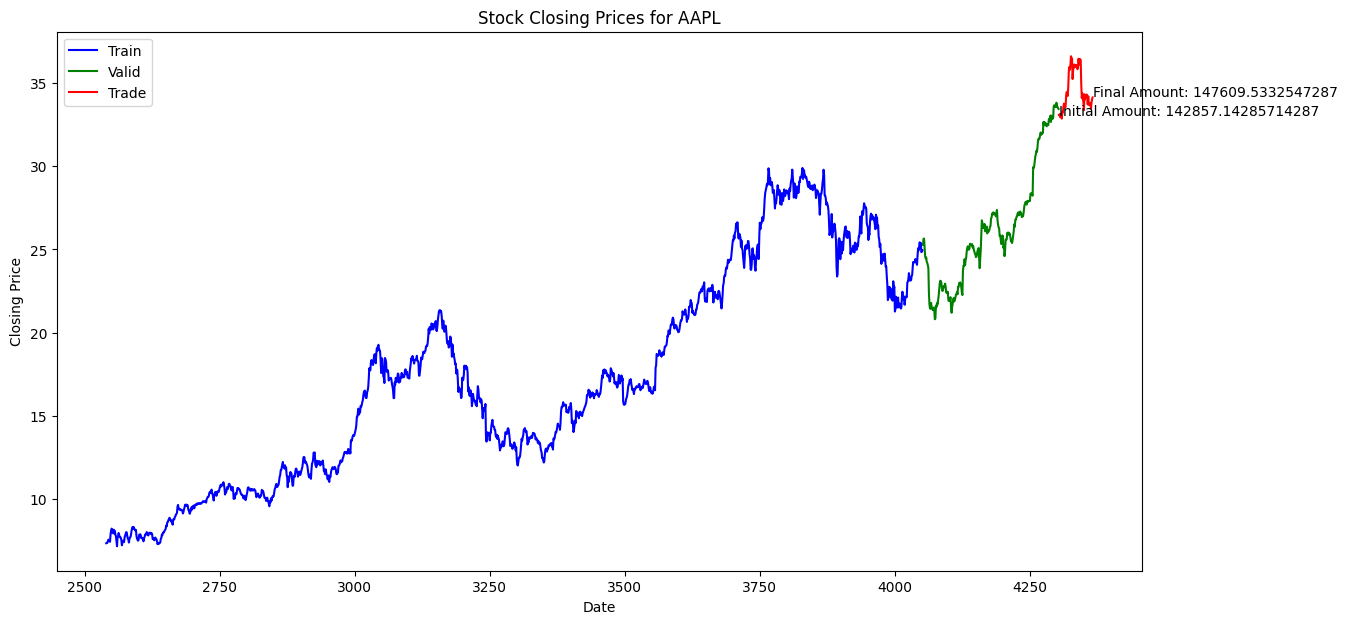

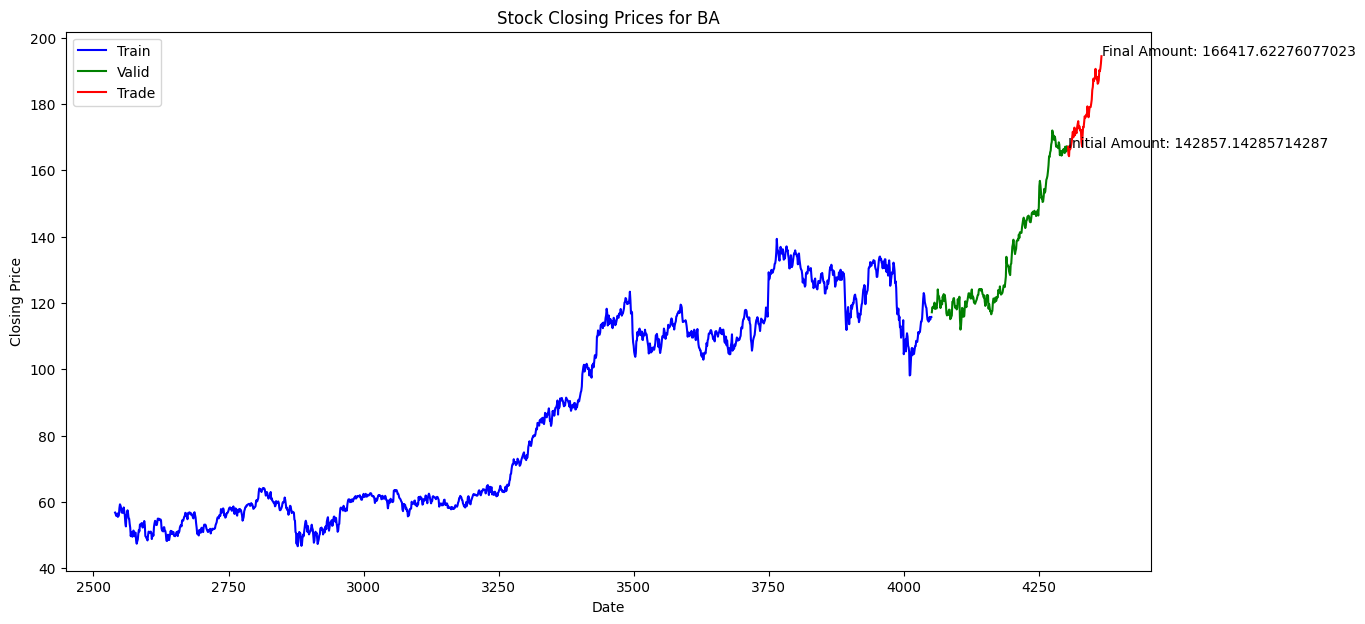

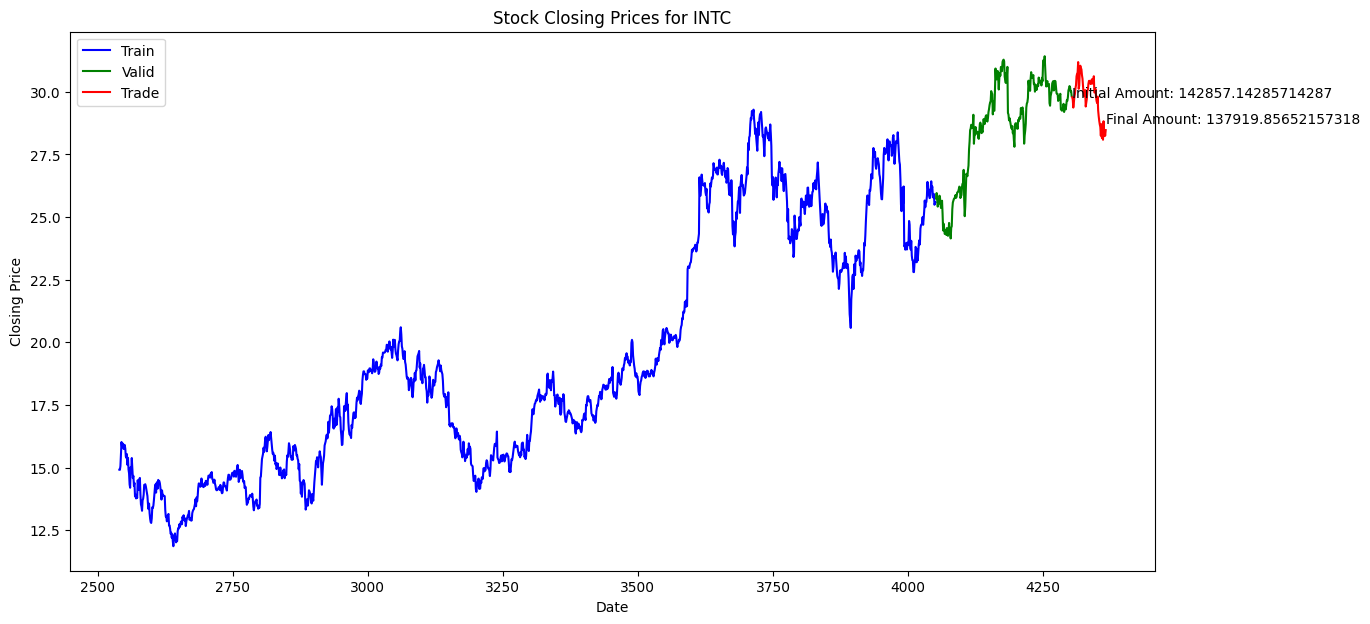

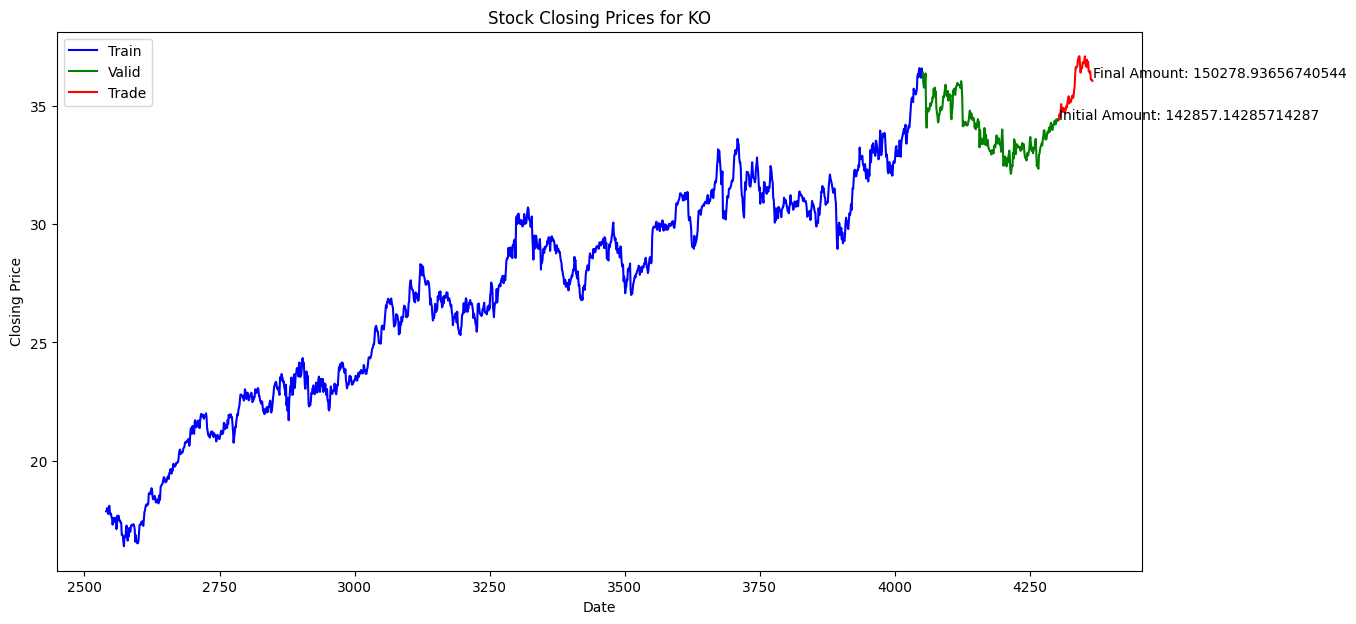

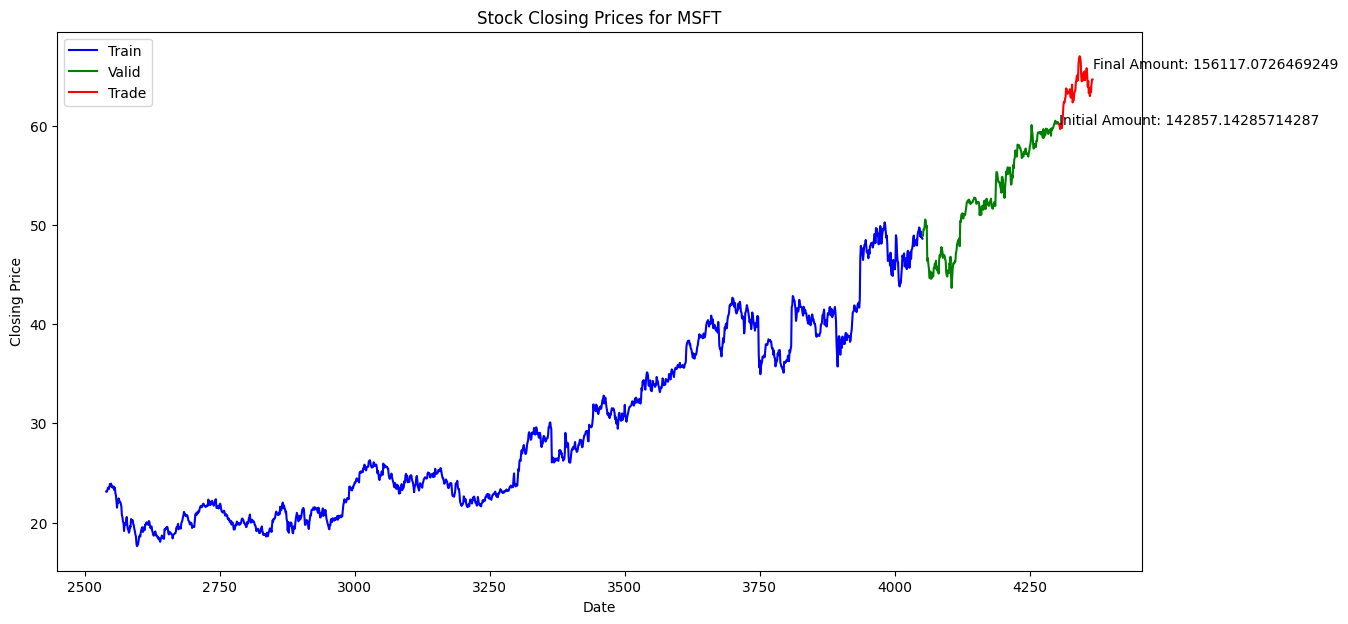

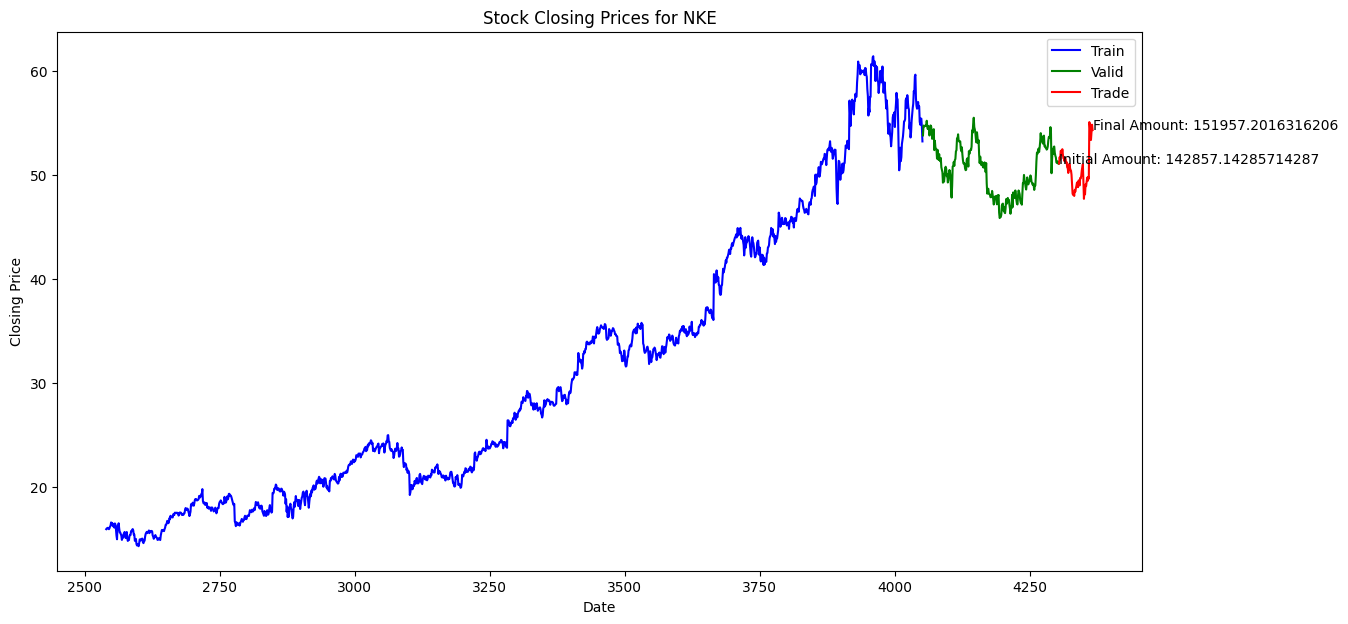

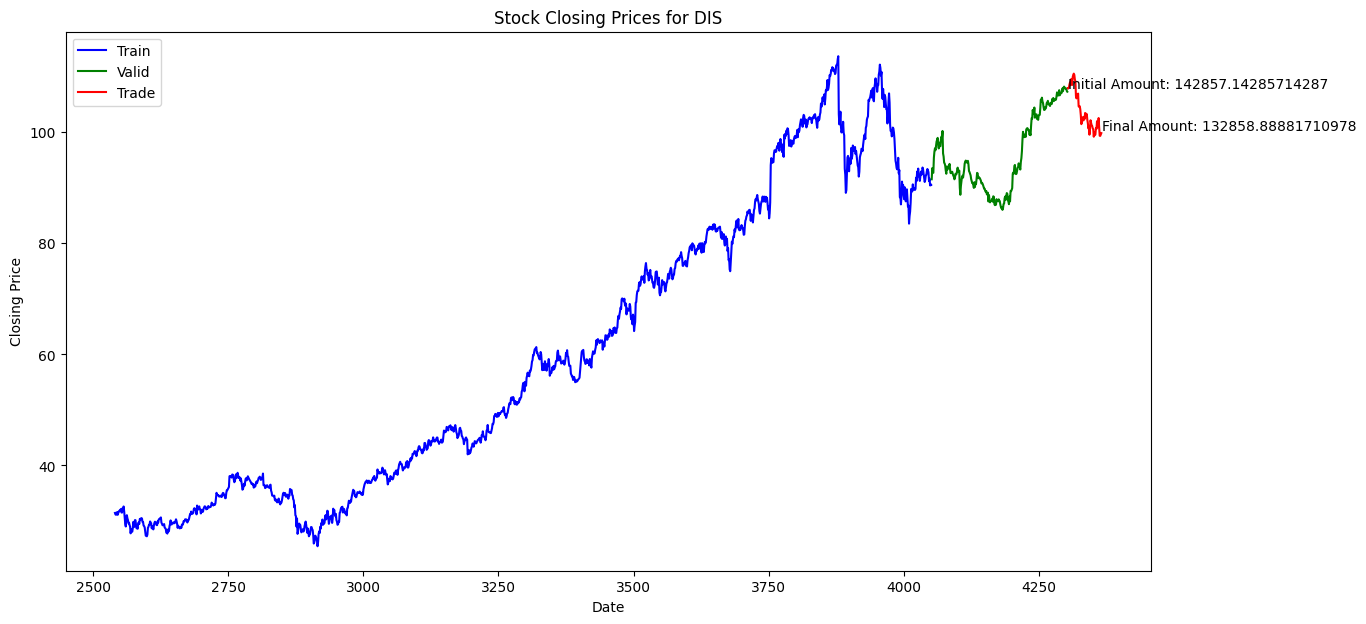

cycle
0
train indexes
17780 28364
validation indexes
28364 30128
lenght of the datasets:
10584 1764
min and max train date
2010-04-09 2016-04-11
min and max validation date
2016-04-12 2017-04-10
train dataset.shape
(10584, 13)
validation dataset.shape
(1764, 13)
 - insample_turbulence_threshold: - 
1.7663442213946396
 - historical_turbulence_mean: - 
0.8687405171256483
 - Turbulence_threshold: - 
6.4226045282797015

 - Model train from:  2010-04-09 to  2017-04-10
asset memory reset initial [1000000]
init_obs reset
asset memory reset initial [1000000]


C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


TRAIN STEP TERMINAL A2C_selected_timesteps10000 over steps: 0 1763
TRAIN initial asset 1000000
TRAIN end_total_asset 2266096.982101924
TRAIN total_reward 1266096.9821019238 == 1266096.9821019238
TRAIN total_cost:  338833.6178279155
TRAIN total trades:  11403
TRAIN Sharpe Ratio:  0.8045019276293592 ,

TRAIN STEP TERMINAL A2C_selected_timesteps10000 over steps: 1763 3526
TRAIN initial asset 2266096.982101924
TRAIN end_total_asset 5421162.495828919
TRAIN total_reward 3155065.5137269953 == 3155065.5137269953
TRAIN total_cost:  1222653.8308309654
TRAIN total trades:  23030
TRAIN Sharpe Ratio:  0.8482948354151317 ,

TRAIN STEP TERMINAL A2C_selected_timesteps10000 over steps: 3526 5289
TRAIN initial asset 5421162.495828919
TRAIN end_total_asset 11583561.580332987
TRAIN total_reward 6162399.084504068 == 6162399.084504068
TRAIN total_cost:  3240560.895933227
TRAIN total trades:  34750
TRAIN Sharpe Ratio:  0.7576217760289324 ,

TRAIN STEP TERMINAL A2C_selected_timesteps10000 over steps: 5289 705

C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



self.day 4361
hmax: 1007.0077651496597

initial actions [ 1.         -0.9302419  -0.6046085   0.95463276 -0.4343456   1.
 -0.7155504 ]
final actions [1007.00775 -936.7608  -608.8454   961.3226  -437.38937 1007.00775
 -720.5648 ]
--------------------------   SELL    ---------------------------
asset (increment) after sell: 73004.17002971181
=
self.state[index+1] 101.41661834716795
*
min(abs(action),self.state[index+self.stocks_dim+1]) 720.5648
*
(1- self.transaction_cost_pct) 0.999

asset (without stock return) after sell: 73039.99172756069
------------------------------------------------------------------
--------------------------   SELL    ---------------------------
asset (increment) after sell: 17226.615161927344
=
self.state[index+1] 28.322229385375977
*
min(abs(action),self.state[index+self.stocks_dim+1]) 608.8454
*
(1- self.transaction_cost_pct) 0.999

asset (without stock return) after sell: 90266.60688948803
------------------------------------------------------------------
-

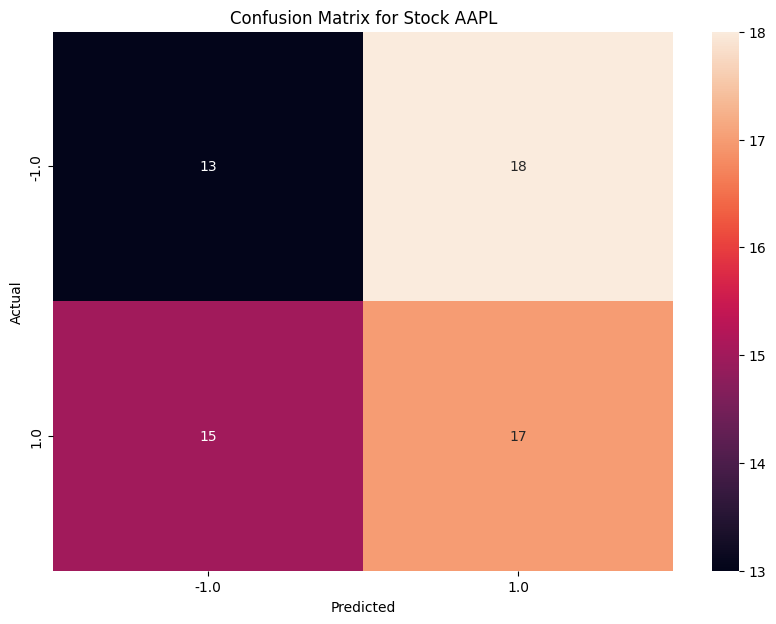


Pred VS Actual values for Stock BA:
[(4304, ('Pred:', -713.3929, '-->', -1.0), ('Act:', 166.98411560058594, 166.0396270751953, '-->', 1.0)), (4305, ('Pred:', 1000.42377, '-->', 1.0), ('Act:', 164.6276092529297, 166.98411560058594, '-->', -1.0)), (4306, ('Pred:', -876.59784, '-->', -1.0), ('Act:', 164.22549438476562, 164.6276092529297, '-->', -1.0)), (4307, ('Pred:', 996.54626, '-->', 1.0), ('Act:', 167.40489196777344, 164.22549438476562, '-->', 1.0)), (4308, ('Pred:', 512.3844, '-->', 1.0), ('Act:', 166.31082153320312, 167.40489196777344, '-->', -1.0)), (4309, ('Pred:', 1002.07404, '-->', 1.0), ('Act:', 166.8251495361328, 166.31082153320312, '-->', 1.0)), (4310, ('Pred:', -122.08292, '-->', -1.0), ('Act:', 167.66673278808594, 166.8251495361328, '-->', 1.0)), (4311, ('Pred:', -833.32153, '-->', -1.0), ('Act:', 168.67666625976562, 167.66673278808594, '-->', 1.0)), (4312, ('Pred:', -92.23715, '-->', -1.0), ('Act:', 170.24765014648438, 168.67666625976562, '-->', 1.0)), (4313, ('Pred:', -7

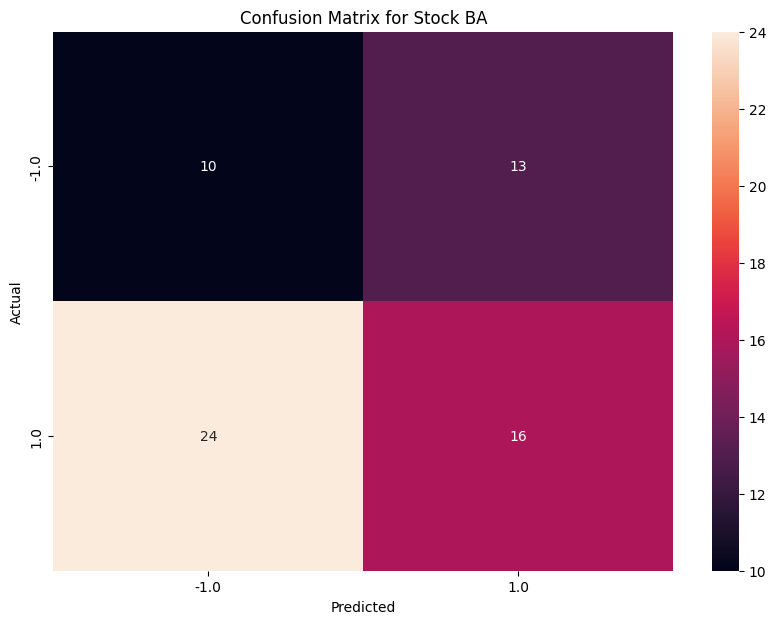


Pred VS Actual values for Stock INTC:
[(4304, ('Pred:', 1000.0, '-->', 1.0), ('Act:', 29.7795467376709, 29.82953453063965, '-->', -1.0)), (4305, ('Pred:', 710.88763, '-->', 1.0), ('Act:', 29.687883377075195, 29.7795467376709, '-->', -1.0)), (4306, ('Pred:', 551.437, '-->', 1.0), ('Act:', 29.37126350402832, 29.687883377075195, '-->', -1.0)), (4307, ('Pred:', -996.54626, '-->', -1.0), ('Act:', 29.56290054321289, 29.37126350402832, '-->', 1.0)), (4308, ('Pred:', 937.7738, '-->', 1.0), ('Act:', 29.804536819458008, 29.56290054321289, '-->', 1.0)), (4309, ('Pred:', 1002.07404, '-->', 1.0), ('Act:', 29.921199798583984, 29.804536819458008, '-->', 1.0)), (4310, ('Pred:', 991.61536, '-->', 1.0), ('Act:', 30.14616203308105, 29.921199798583984, '-->', 1.0)), (4311, ('Pred:', -52.406513, '-->', -1.0), ('Act:', 30.26280975341797, 30.14616203308105, '-->', 1.0)), (4312, ('Pred:', -1008.65936, '-->', -1.0), ('Act:', 30.6211051940918, 30.26280975341797, '-->', 1.0)), (4313, ('Pred:', 588.2955, '-->', 

C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


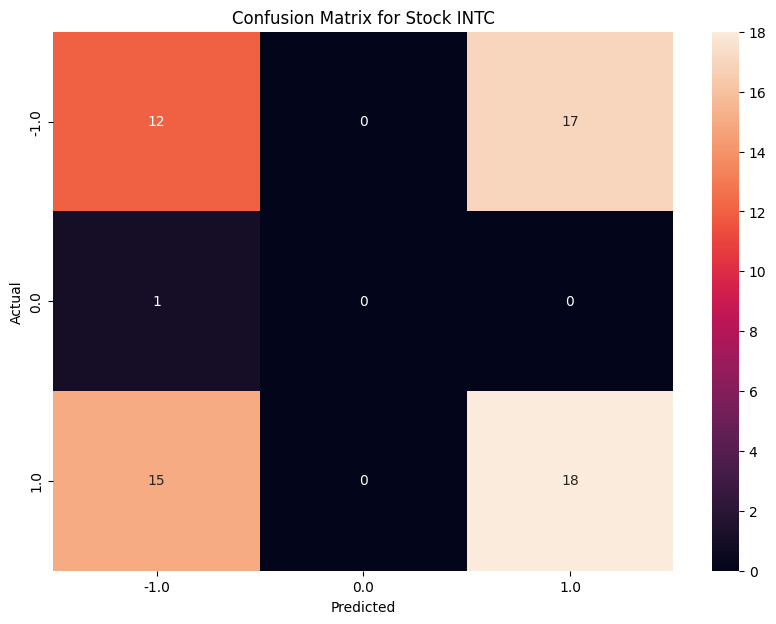


Pred VS Actual values for Stock KO:
[(4304, ('Pred:', -892.445, '-->', -1.0), ('Act:', 34.428096771240234, 34.45230484008789, '-->', -1.0)), (4305, ('Pred:', 243.5186, '-->', 1.0), ('Act:', 34.65407180786133, 34.428096771240234, '-->', 1.0)), (4306, ('Pred:', 707.9154, '-->', 1.0), ('Act:', 34.53302001953125, 34.65407180786133, '-->', -1.0)), (4307, ('Pred:', -849.1399, '-->', -1.0), ('Act:', 34.758995056152344, 34.53302001953125, '-->', 1.0)), (4308, ('Pred:', 282.9888, '-->', 1.0), ('Act:', 35.089874267578125, 34.758995056152344, '-->', 1.0)), (4309, ('Pred:', -1002.07404, '-->', -1.0), ('Act:', 34.88810729980469, 35.089874267578125, '-->', -1.0)), (4310, ('Pred:', 1001.58307, '-->', 1.0), ('Act:', 34.77511215209961, 34.88810729980469, '-->', -1.0)), (4311, ('Pred:', 1008.5187, '-->', 1.0), ('Act:', 34.758995056152344, 34.77511215209961, '-->', -1.0)), (4312, ('Pred:', 1008.65936, '-->', 1.0), ('Act:', 34.92845916748047, 34.758995056152344, '-->', 1.0)), (4313, ('Pred:', -558.54846,

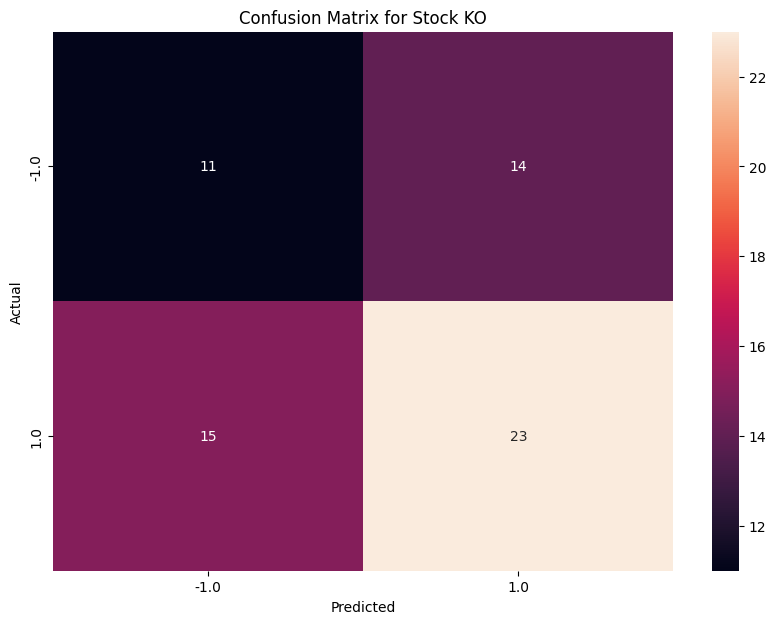


Pred VS Actual values for Stock MSFT:
[(4304, ('Pred:', -1000.0, '-->', -1.0), ('Act:', 60.1490364074707, 60.19496154785156, '-->', -1.0)), (4305, ('Pred:', -179.6289, '-->', -1.0), ('Act:', 59.91938400268555, 60.1490364074707, '-->', -1.0)), (4306, ('Pred:', 218.16052, '-->', 1.0), ('Act:', 59.66217422485352, 59.91938400268555, '-->', -1.0)), (4307, ('Pred:', 494.3151, '-->', 1.0), ('Act:', 60.1490364074707, 59.66217422485352, '-->', 1.0)), (4308, ('Pred:', -140.64389, '-->', -1.0), ('Act:', 60.066349029541016, 60.1490364074707, '-->', -1.0)), (4309, ('Pred:', -73.650955, '-->', -1.0), ('Act:', 59.74485778808594, 60.066349029541016, '-->', -1.0)), (4310, ('Pred:', 216.56372, '-->', 1.0), ('Act:', 60.16740417480469, 59.74485778808594, '-->', 1.0)), (4311, ('Pred:', -1008.5187, '-->', -1.0), ('Act:', 60.99413299560547, 60.16740417480469, '-->', 1.0)), (4312, ('Pred:', -1008.65936, '-->', -1.0), ('Act:', 62.03212356567383, 60.99413299560547, '-->', 1.0)), (4313, ('Pred:', 1010.1738, '--

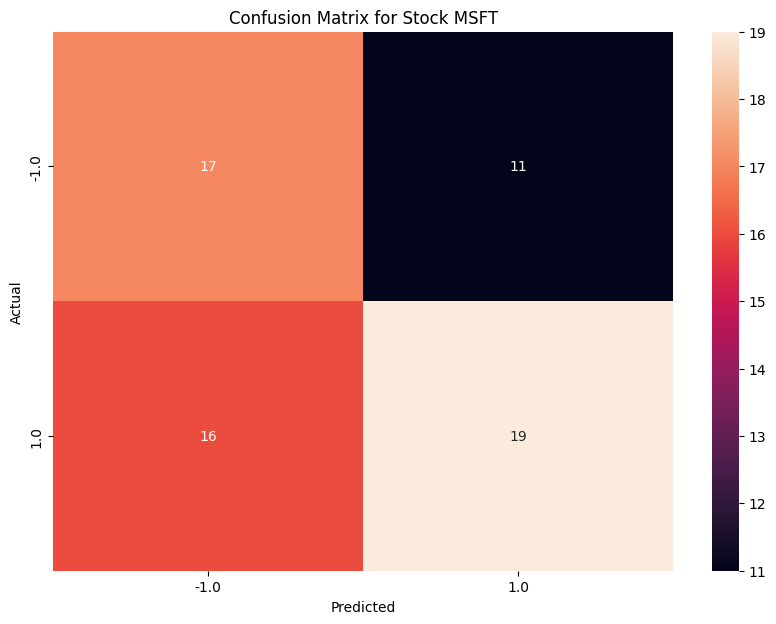


Pred VS Actual values for Stock NKE:
[(4304, ('Pred:', -1000.0, '-->', -1.0), ('Act:', 51.08313751220703, 51.06452941894531, '-->', 1.0)), (4305, ('Pred:', -1000.42377, '-->', -1.0), ('Act:', 51.68772506713867, 51.08313751220703, '-->', 1.0)), (4306, ('Pred:', -387.25345, '-->', -1.0), ('Act:', 51.47378540039063, 51.68772506713867, '-->', -1.0)), (4307, ('Pred:', 35.128235, '-->', 1.0), ('Act:', 52.3109245300293, 51.47378540039063, '-->', 1.0)), (4308, ('Pred:', -1002.597, '-->', -1.0), ('Act:', 52.18999481201172, 52.3109245300293, '-->', -1.0)), (4309, ('Pred:', 534.4612, '-->', 1.0), ('Act:', 51.95746994018555, 52.18999481201172, '-->', -1.0)), (4310, ('Pred:', 836.68494, '-->', 1.0), ('Act:', 52.45974349975586, 51.95746994018555, '-->', 1.0)), (4311, ('Pred:', -713.9766, '-->', -1.0), ('Act:', 51.94815826416016, 52.45974349975586, '-->', -1.0)), (4312, ('Pred:', 1008.65936, '-->', 1.0), ('Act:', 51.594722747802734, 51.94815826416016, '-->', -1.0)), (4313, ('Pred:', -1010.1738, '-->

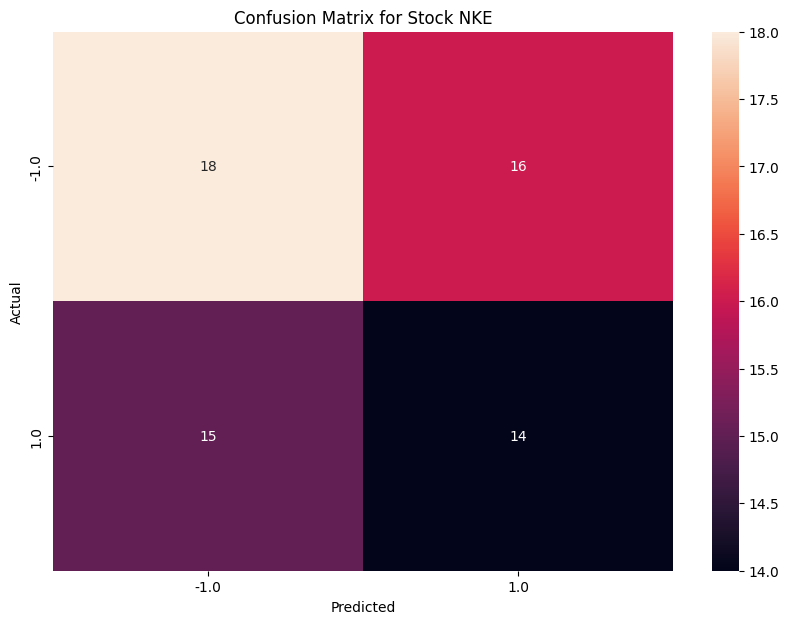


Pred VS Actual values for Stock DIS:
[(4304, ('Pred:', 1000.0, '-->', 1.0), ('Act:', 107.92638397216795, 107.31549835205078, '-->', 1.0)), (4305, ('Pred:', 1000.42377, '-->', 1.0), ('Act:', 107.89774322509766, 107.92638397216795, '-->', -1.0)), (4306, ('Pred:', 417.4039, '-->', 1.0), ('Act:', 108.05046844482422, 107.89774322509766, '-->', 1.0)), (4307, ('Pred:', 996.54626, '-->', 1.0), ('Act:', 108.60407257080078, 108.05046844482422, '-->', 1.0)), (4308, ('Pred:', -676.9639, '-->', -1.0), ('Act:', 108.99542999267578, 108.60407257080078, '-->', 1.0)), (4309, ('Pred:', 961.05914, '-->', 1.0), ('Act:', 108.5563507080078, 108.99542999267578, '-->', -1.0)), (4310, ('Pred:', -132.80457, '-->', -1.0), ('Act:', 109.56813049316406, 108.5563507080078, '-->', 1.0)), (4311, ('Pred:', 1008.5187, '-->', 1.0), ('Act:', 109.23406219482422, 109.56813049316406, '-->', -1.0)), (4312, ('Pred:', -1008.65936, '-->', -1.0), ('Act:', 108.52772521972656, 109.23406219482422, '-->', -1.0)), (4313, ('Pred:', -19

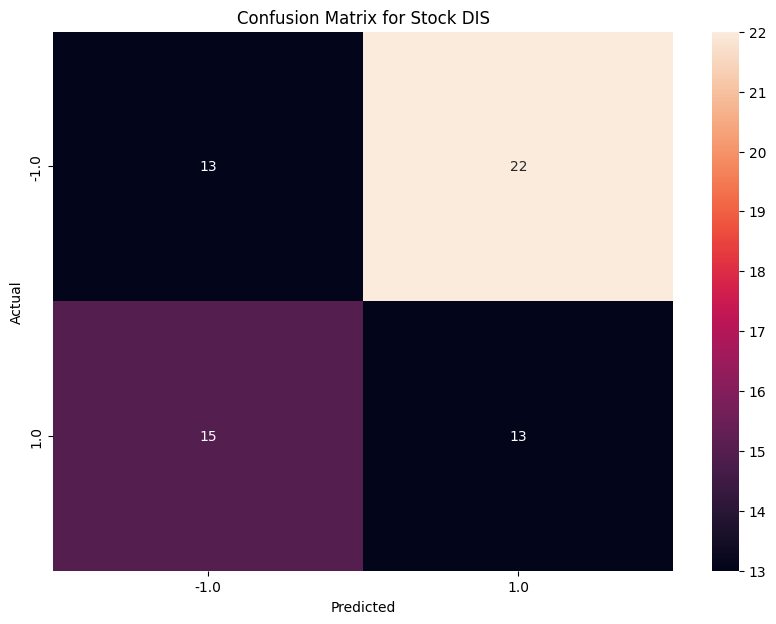

Whole Strategy took:  0.47911300261815387  minutes
Steady Total Asset Revenue: 1043159.1122001328


In [10]:
run_strategy( df=df, 
              date_start=config_.date_start,
              train_init_quarters=config_.train_init_quarters, 
              valid_quarters=config_.valid_quarters, 
              trade_quarters=config_.trade_quarters, 
              max_rebalances_input=config_.max_rebalances_input, 
              rebalance_quarters=config_.rebalance_quarters)

In [11]:
# 5080 9616
# 2010-04-09 to  2020-04-13

In [12]:
# df[df.Date == '2010-04-09']

In [13]:
# df[df.Date == '2020-04-13']

In [14]:
# def func(**kwargs):
#     for key, value in kwargs.items():
#         print(f"{key}: {value}")

# func(a=1, b=2, c=3)